In [1]:
# basis: Legendre-Gauss-Lobatto
using Trixi, LinearAlgebra, OrdinaryDiffEq, Plots
polydeg = 3 #= polynomial degree =#
basis = LobattoLegendreBasis(polydeg)
nodes = basis.nodes # Gauss-Lobatto nodes in [-1, 1]
D = basis.derivative_matrix
M = diagm(basis.weights) # mass matrix
B = diagm([-1; zeros(polydeg - 1); 1])

# mesh
coordinates_min = -1.0 # minimum coordinate
coordinates_max = 1.0  # maximum coordinate
n_elements      = 16   # number of elements

dx = (coordinates_max - coordinates_min) / n_elements # length of one element

x = Matrix{Float64}(undef, length(nodes), n_elements)
for element in 1:n_elements
    x_l = -1 + (element - 1) * dx + dx/2
    for i in 1:length(nodes) # basis points in [-1, 1]
        ξ = nodes[i]
        x[i, element] = x_l + dx/2 * ξ
    end
end



In [2]:
# initial condition
initial_condition_sine_wave(x) = 1.0 + 0.5 * sin(pi * x)
u0 = initial_condition_sine_wave.(x)

plot(vec(x), vec(u0), label="initial condition", legend=:topleft)

# flux Lax-Friedrichs
surface_flux = flux_lax_friedrichs

# rhs! method
function rhs!(du, u, x, t)
    # reset du
    du .= zero(eltype(du))
    flux_numerical = copy(du)

    # calculate interface and boundary fluxes
    equations = LinearScalarAdvectionEquation1D(1.0)
    for element in 2:n_elements-1
        # left interface
        flux_numerical[1, element] = surface_flux(u[end, element-1], u[1, element], 1, equations)
        flux_numerical[end, element-1] = flux_numerical[1, element]
        # right interface
        flux_numerical[end, element] = surface_flux(u[end, element], u[1, element+1], 1, equations)
        flux_numerical[1, element+1] = flux_numerical[end, element]
    end
    # boundary flux
    flux_numerical[1, 1] = surface_flux(u[end, end], u[1, 1], 1, equations)
    flux_numerical[end, end] = flux_numerical[1, 1]



ErrorException: syntax: incomplete: "function" at Untitled-1.ipynb:11 requires end

In [3]:
    # calculate surface integrals
    for element in 1:n_elements
        du[:, element] -= (M \ B) * flux_numerical[:, element]
    end

    # calculate volume integral
    for element in 1:n_elements
        flux = u[:, element]
        du[:, element] += (M \ transpose(D)) * M * flux
    end

    # apply Jacobian from mapping to reference element
    for element in 1:n_elements
        du[:, element] *= 2 / dx
    end

    return nothing
end

# create ODE problem
tspan = (0.0, 2.0)
ode = ODEProblem(rhs!, u0, tspan, x)

# solve
sol = solve(ode, RDPK3SpFSAL49(), abstol=1.0e-6, reltol=1.0e-6, save_everystep=false)

plot(vec(x), vec(sol.u[end]), label="solution at t=$(tspan[2])", legend=:topleft, lw=3)

UndefVarError: UndefVarError: du not defined

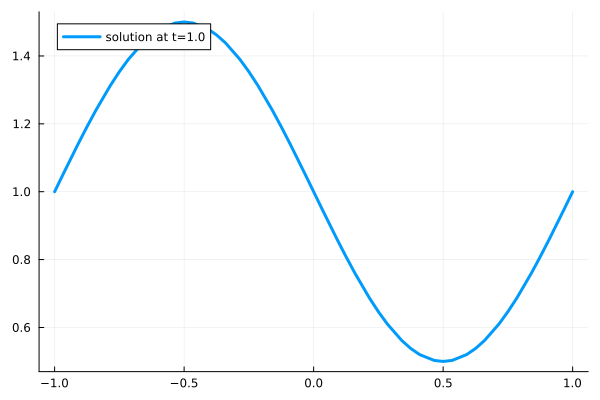

In [5]:
# basis: Legendre-Gauss-Lobatto
using Trixi, LinearAlgebra, OrdinaryDiffEq, Plots
polydeg = 3 #= polynomial degree =#
basis = LobattoLegendreBasis(polydeg)
nodes = basis.nodes # Gauss-Lobatto nodes in [-1, 1]
D = basis.derivative_matrix
M = diagm(basis.weights) # mass matrix
B = diagm([-1; zeros(polydeg - 1); 1])

# mesh
coordinates_min = -1.0 # minimum coordinate
coordinates_max = 1.0  # maximum coordinate
n_elements      = 16   # number of elements

dx = (coordinates_max - coordinates_min) / n_elements # length of one element

x = Matrix{Float64}(undef, length(nodes), n_elements)
for element in 1:n_elements
    x_l = -1 + (element - 1) * dx + dx/2
    for i in 1:length(nodes) # basis points in [-1, 1]
        ξ = nodes[i]
        x[i, element] = x_l + dx/2 * ξ
    end
end

# initial condition
initial_condition_sine_wave(x) = 1.0 + 0.5 * sin(pi * x)
u0 = initial_condition_sine_wave.(x)

plot(vec(x), vec(u0), label="initial condition", legend=:topleft)

# flux Lax-Friedrichs
surface_flux = flux_lax_friedrichs

# rhs! method
function rhs!(du, u, x, t)
    # reset du
    du .= zero(eltype(du))
    flux_numerical = copy(du)

    # calculate interface and boundary fluxes
    equations = LinearScalarAdvectionEquation1D(1.0)
    for element in 2:n_elements-1
        # left interface
        flux_numerical[1, element] = surface_flux(u[end, element-1], u[1, element], 1, equations)
        flux_numerical[end, element-1] = flux_numerical[1, element]
        # right interface
        flux_numerical[end, element] = surface_flux(u[end, element], u[1, element+1], 1, equations)
        flux_numerical[1, element+1] = flux_numerical[end, element]
    end
    # boundary flux
    flux_numerical[1, 1] = surface_flux(u[end, end], u[1, 1], 1, equations)
    flux_numerical[end, end] = flux_numerical[1, 1]

    # calculate surface integrals
    for element in 1:n_elements
        du[:, element] -= (M \ B) * flux_numerical[:, element]
    end

    # calculate volume integral
    for element in 1:n_elements
        flux = u[:, element]
        du[:, element] += (M \ transpose(D)) * M * flux
    end

    # apply Jacobian from mapping to reference element
    for element in 1:n_elements
        du[:, element] *= 2 / dx
    end

    return nothing
end

# create ODE problem
tspan = (0.0, 1.0)
ode = ODEProblem(rhs!, u0, tspan, x)

# solve
sol = solve(ode, RDPK3SpFSAL49(), abstol=1.0e-6, reltol=1.0e-6, save_everystep=false)

plot(vec(x), vec(sol.u[end]), label="solution at t=$(tspan[2])", legend=:topleft, lw=3)